# Group Project Proposal

Group: 83
<br> Guozheng Gong, Brianna Zhou, Saakshith Manjunath, Hrishikesh Rakeshkumar Dalal

### Title: A Model for the Prediction of Heart Diease

### Introduction:
We are using a dataset about heart disease from the UCI Machine Learning Repository. We will be using the Cleveland version of the database. Heart disease is one of the leading causes of death around the world. Studies show that the following vital signs are related to heart disease:
- trestbps: resting blood pressure (in mm Hg)
- chol: serum cholesterol (in mg/dl)
- thalach: maximum heart rate achieved in beats each minute (bpm)
- age: age (in years)
So we will be looking at these columns only to choose our predictors.

Predictive question: Can we use a person’s vital signs to predict whether they have heart disease or not?



### Preliminary exploratory data analysis:

In [1]:
library(tidyverse) #first run this to load package
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
download.file(url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
              destfile = "data/processed.cleveland.data")
data <- read_csv(file = "data/processed.cleveland.data", 
                 col_names = c("age","sex","cp","trestbps","chol","fbs","restecg","thalach",
                               "exang","oldpeak","slope","ca","thal","num_the_predicted_attribute"))

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


According to the data description,  experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0). So for this project, values 1,2,3,4 have the same meaning (presence of heart disease), so we are converting the values 2,3,4 in num_the_predicted_attribute to 1. We are also editing the column type to treat these values as factors and not numerical data.

In [3]:
data1 <- filter(data, num_the_predicted_attribute <=1)
data2 <- filter(data, num_the_predicted_attribute > 1)
data2 <- mutate(data2, num_the_predicted_attribute = 1)
data <- merge(data1, data2, all = T)
data <- mutate(data, num_the_predicted_attribute = as_factor(num_the_predicted_attribute))
#change num_the_predicted_attribute to be factor

In [4]:
#Selecting only the cloumns we need
data <- select(data, age, trestbps, chol, thalach, num_the_predicted_attribute)

Now, we are splitting our data set into training and testing data. We are using 75% of the data as training data.

In [5]:
data_split <- initial_split(data, prop = 0.75, strata = num_the_predicted_attribute) 
data_train <- training(data_split)   
data_test <- testing(data_split)

Using group_by + summarize to compute the mean of each of the columns for every possible predicted variable (i.e., 0 = absence of heart disease, 1 = presence of heart disease):

In [6]:
summary_data <- group_by(data_train,num_the_predicted_attribute) |>
    summarize(trestbps_mean = mean(trestbps), 
              chol_mean = mean(chol),
              age_mean = mean(age),
              thalach_mean=mean(thalach), n=n())
summary_data

num_the_predicted_attribute,trestbps_mean,chol_mean,age_mean,thalach_mean,n
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,129.4309,244.6179,52.86992,158.3252,123
1,135.1923,251.4712,57.09615,140.3750,104


Counting the missing data in each column:

In [7]:
missing_data <- data %>%
    map_df(is.na) %>%
    map_df(sum)
missing_data

age,trestbps,chol,thalach,num_the_predicted_attribute
<int>,<int>,<int>,<int>,<int>
0,0,0,0,0


It looks like there is no missing data.

Now, to visalize the data, we will plot a cholesterol vs. heart rate scatter plot.

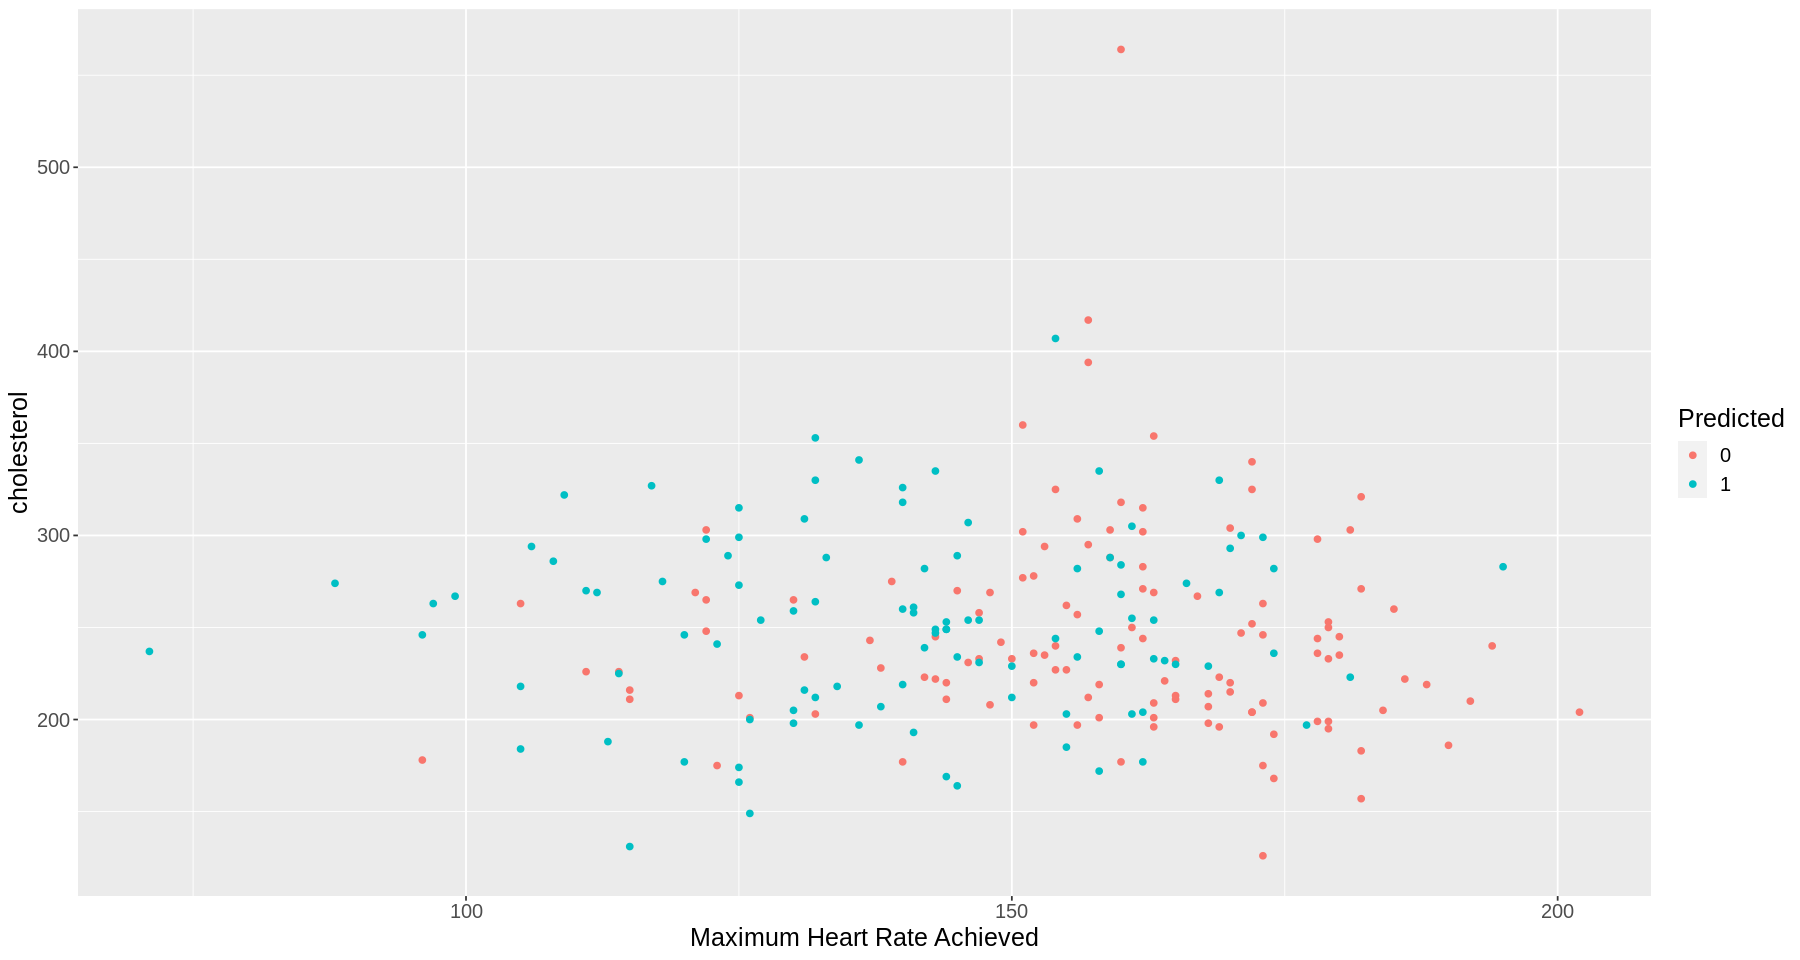

In [8]:
options(repr.plot.width = 15, repr.plot.height = 8) 

chol_v_hr_plot <- data_train |>
ggplot(aes(x = thalach, y = chol, colour = num_the_predicted_attribute)) +
geom_point() +
labs(x = "Maximum Heart Rate Achieved", y = "cholesterol", colour = "Predicted") +
theme(text=element_text(size=15))

chol_v_hr_plot



From the scatterplot, there does seem to be any relationship between the two variables, Cholesterol and Maximum Heart Rate Achieved. However, we can observe that the most of the red points lie between a heart rate of 150-200 bpm and the most of the blue points lie between 100-150 bpm. So, people without heart disease seem to have a higher heart rate than the people with heart disease.

### Methods:
We will use the columns chol and thalach as predictors for our data analysis because they have a larger difference in values for people with and without heart disease, compared to the other variables we considered (referring to the summary table).
We will perform our analysis in three steps:
1. Cross-validation to find the best value of K:
We will split the training data into 5-folds and perform 5-fold cross-validation, create a recipe, and make a model using the training data. Then we will combine these into workflow and generate the metrics to find the most accurate K.

2. Make a new model with the best K value:
Here, we use the best value of K from the previous step to retrain our model and to fit it to our training data.

3. Test the model on the testing data:
We will use our trained model on the testing data and then use its metrics to check how well the model worked in classifying the data.

To visualize the results, we will use a bar graph to see how many of the observations were predicted accurately and how many were not. 


### Expected outcomes and significance:
We expect to find that our model is reasonably accurate in predicting whether a person has heart disease or not based on their vital signs (in this case, heart rate and cholesterol). We would also hopefully be able to observe the range of values for a predictor where our model works well and the range where it does not.

Impact: Once we find out the range where the model works or does not work, we will be able judge if the model will be reliable or not when we try to classify a new observation. 

Future questions:
- How do we prevent heart disease based on our predictions?
- Can we also classify different types of heart disease?
